In [1]:
# Load packages
import matplotlib.pyplot as plt
import numpy as np

In [2]:
def epoching(subj, seed):
	"""This function first converts the EEG data to MNE raw format, and
	performs channel selection, epoching, baseline correction and frequency
	downsampling. Then, it sorts the EEG data of each session according to the
	image conditions.

	Parameters
	----------
	args : Namespace
		Input arguments.
	seed : int
		Random seed.

	Returns
	-------
	epoched_data : list of float
		Epoched EEG data.
	img_conditions : list of int
		Unique image conditions of the epoched and sorted EEG data.
	ch_names : list of str
		EEG channel names.
	times : float
		EEG time points.

	"""

	import os
	import mne
	import numpy as np
	from sklearn.utils import shuffle

	### Loop across data collection sessions ###
	epoched_data = []
	img_conditions = []
	for s in range(1):
		# Load the BDF file
		fif_file_path = os.path.join('/srv/eeg_reconstruction/shared/biosemi-dataset', 'fif', "subj0" + str(subj) + "_session" + str(s+1) + "_eeg.fif") 
		raw = mne.io.read_raw_fif(fif_file_path, preload=True)
		montage = mne.channels.make_standard_montage('standard_1020')
		raw.set_montage(montage)

		# Rereferencing electrodes
		raw.set_eeg_reference('average', projection=False)

		# Epoch into events and drop channels
		events = mne.find_events(raw)
		epochs = mne.Epochs(raw, events, tmin=0.05, tmax=0.70, baseline=(0.05,0.1), preload=True) # Manually move trigger back 100ms
		epochs.drop_channels(['Status'])
		epochs.shift_time(tshift=-0.1, relative=True)
		ch_names = epochs.ch_names
		times = epochs.times

		data = epochs.get_data(copy=True)
		events = epochs.events[:,2]
		img_cond = np.unique(events) # this is sorted
		del epochs
		max_rep = 4

		epoched_data = []
		img_conditions = []

		# Sorted data matrix of shape:
		# Image conditions × EEG repetitions × EEG channels × EEG time points
		sorted_data = np.zeros((len(img_cond),max_rep,data.shape[1], data.shape[2]))
		for i in range(len(img_cond)):
			# Find the indices of the selected image condition
			idx = np.where(events == img_cond[i])[0]
			# Patch for when # events < max_rep
			if len(idx) < max_rep:
				# Repeat idx elements until it reaches or exceeds max_rep
				idx = np.resize(idx, max_rep)
			# Randomly select only the max number of EEG repetitions
			idx = shuffle(idx, random_state=seed, n_samples=max_rep)
			sorted_data[i] = data[idx]
		del data
		epoched_data.append(sorted_data[:, :, :, int(0.05*512):])
		img_conditions.append(img_cond)
		times = times[int(0.05*512):]
		del sorted_data

	### Output ###
	return epoched_data, img_conditions, ch_names, times

In [3]:
epoched, img_conds, ch_names, times = epoching(1, 20200220)

Opening raw data file /srv/eeg_reconstruction/shared/biosemi-dataset/fif/subj01_session1_eeg.fif...
Isotrak not found
    Range : 0 ... 1778687 =      0.000 ...  3473.998 secs
Ready.
Reading 0 ... 1778687  =      0.000 ...  3473.998 secs...
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.
3839 events found on stim channel Status
Event IDs: [  1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17  18
  19  20  21  22  23  24  25  26  27  28  29  30  31  32  33  34  35  36
  37  38  39  40  41  42  43  44  45  46  47  48  49  50  51  52  53  54
  55  56  57  58  59  60  61  62  63  64  65  66  67  68  69  70  71  72
  73  74  75  76  77  78  79  80  81  82  83  84  85  86  87  88  89  90
  91  92  93  94  95  96  97  98  99 100 101 102 103 104 105 106 107 108
 109 110 111 112 113 114 115 116 117 118 119 120 121 122 123 124 125 126
 127 128 129 130 131 132 133 134 135 136 137 138 139 140 141 142 143 144
 145 146 147

In [4]:
# TEMP HACK: We assume epoched is len 1, (we look at only 1)
num_train = int(len(epoched[0]) * 0.8)
epoched_train = [epoched[0][:num_train]]
img_conditions_train = [img_conds[0][:num_train]]
epoched_test = [epoched[0][num_train:]]

In [35]:
epoched_train = np.array(epoched_train)
epoched_test = np.array(epoched_test)
epoched = np.array(epoched)
# (num_sessions, conditions, reps, channels, timepoints)

(1, 960, 4, 64, 308)

In [9]:
# P1 ERP component, should have positive polarity
time_win = (.080, .140)
electrodes = ('O1', 'O2', 'PO7', 'PO8', 'Pz', 'P3', 'P4')
roi = [ch_names.index(e) for e in electrodes]

In [39]:
def plot_single_channel_erp(subEegData, channels, electrodes, times):
    imgEegData = np.mean(subEegData, axis=0)
    erp = np.mean(imgEegData, axis=0)
    data = erp
    
    plt.figure(figsize=(16,10))

    for i in np.where(np.isin(ch_names, electrodes))[0]:
        print(i)
        plt.plot(times, data[i], label=ch_names[i])  # Plot each row as a separate line
        
    # Add labels and title
    plt.title("Raw Single-channel ERP (Averaged across conditions and repetitions)")
    plt.xlabel("Time (s)")
    plt.ylabel("Voltage")

    # Show legend
    plt.legend()

    # Display the plot
    plt.show()

20
24
26
30
57
61
63


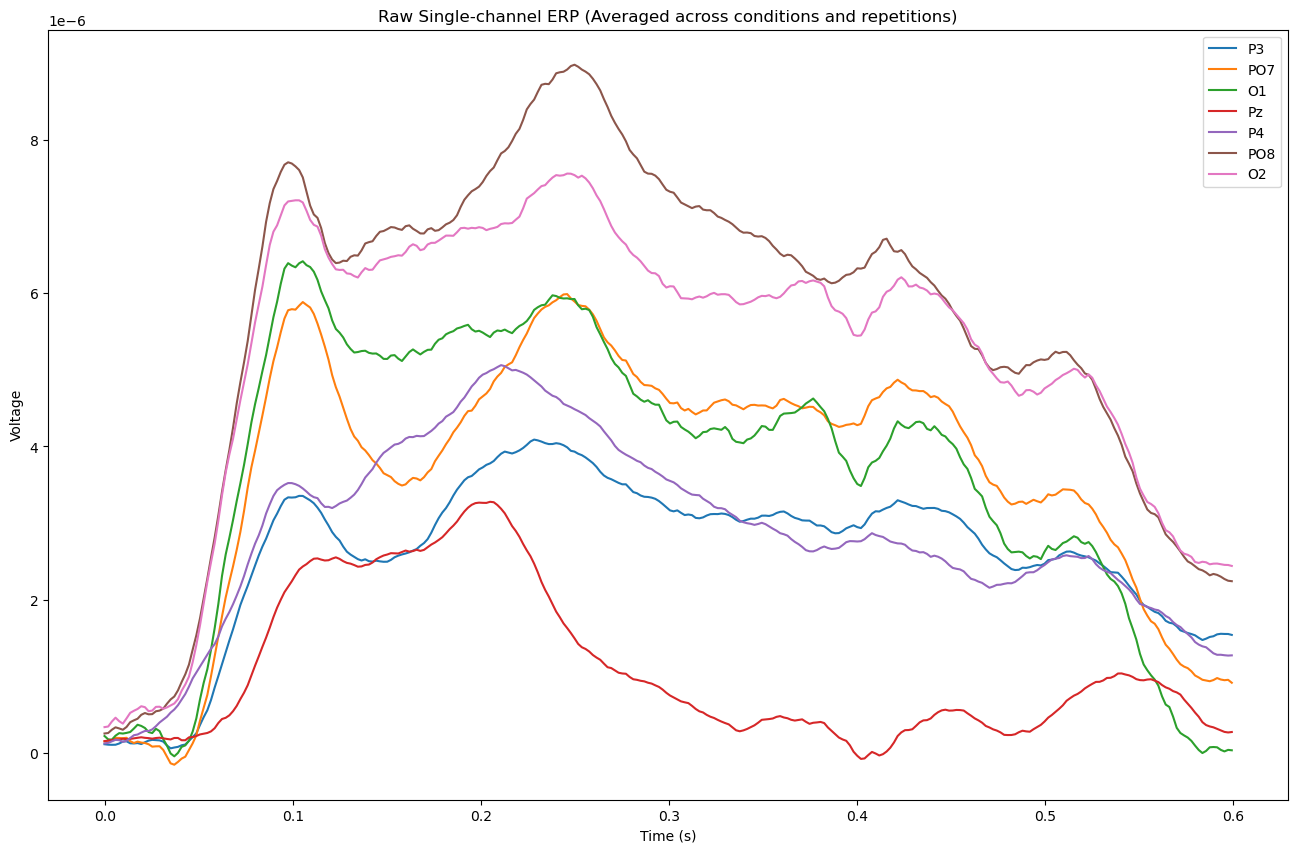

In [40]:
plot_single_channel_erp(epoched_train[0], ch_names, electrodes, times)

